In [1]:
import pandas as pd
import pickle as pkl
import seaborn as sns
from numpy import mean
from matplotlib import pyplot as plt
import lightgbm as lgbm

In [2]:
%cd /Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital/

/Users/josefinadallavia/Documents/MIM/Tesis/AML-hospital


### Load model

In [3]:
with open(r"experiments/optimized_gdbt_model.pkl", "rb") as input_file:
    lgbm_model = pkl.load(input_file)

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/Users/josefinadallavia/opt/anaconda3/lib/python3.7/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


### Load data

In [4]:
import os
import pandas as pd
from matplotlib import pyplot as plt   
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from thesis_lib.utils import * 
from thesis_lib.modelling.data import *
from thesis_lib.modelling.model import *
data = Data().load('data/hospital_dataset')
data.get_stats()

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet


dataset_type,train,val,test
n_observations,319150,33482,33309
relative_size,0.82694,0.0867542,0.0863059
n_cols,71,71,71
positives,42697,4555,4507
negatives,276453,28927,28802
positive_prop,0.133783,0.136043,0.135309
negative_prop,0.866217,0.863957,0.864691
min_date,2017-01-01,2018-11-11,2018-11-11
max_date,2018-11-10,2019-11-11,2019-11-11


### Generate probabilities

In [5]:
lgbm_model.transform(data, transform_test=True)

Fitting pipeline...
Transforming data...


In [6]:
predicted_prob_test = lgbm_model.predict(lgbm_model.X_test)
y_test_pred = pd.DataFrame({'predicted_prob':predicted_prob_test})

In [7]:
data.test.X.reset_index(inplace=True)

X_test= data.test.X.join(y_test_pred)
y_test = data.test.y.reset_index()
X_test = X_test.join(y_test['discharge'])
#pd.set_option('display.max_columns', None)
df = X_test[['date','predicted_prob','discharge']]

In [8]:
df.to_parquet('test_data_w_predictions.parquet')

### Simulate forecast

In [9]:
from tqdm import tqdm

results = {'threshold': [],
           'date':[],
           'actual_discharges': [],
           'predicted_discharges': [],
           'patients': []}

unique_dates = list(df.date.unique())

for i in tqdm(range(0,100,1)):
    threshold = i/100
    df['predicted_discharges'] = df['predicted_prob'].apply(lambda x:1 if x > threshold else 0)
    
    for date in unique_dates:
        #Filter df
        df_date =  df[df['date'] == date]
        discharges = df_date['discharge'].sum()
        predicted_discharges = df_date['predicted_discharges'].sum()
        n_patients = len(df_date)
        
        
        #Save data in dict
        results['threshold'].append(float(threshold))
        results['date'].append(date)
        results['actual_discharges'].append(discharges)
        results['predicted_discharges'].append(predicted_discharges)
        results['patients'].append(n_patients)

  0%|          | 0/100 [00:00<?, ?it/s]/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
100%|██████████| 100/100 [01:29<00:00,  1.12it/s]


In [10]:
prediction_results = pd.DataFrame(results)

In [11]:
prediction_results['predicted_discharges_happened'] = (prediction_results['actual_discharges'] > 
                                                       prediction_results['predicted_discharges'])

In [12]:
import datetime
pd.set_option('display.max_rows', 100)
sample = prediction_results[(prediction_results['date'] == datetime.date(2019,11,9))]

In [32]:
sample.rename(columns={'patients':'observations'}, inplace=True)

In [36]:
sample[sample.threshold *100 % 10 == 0].reset_index().drop(['index'],axis='columns')

,threshold,date,actual_discharges,predicted_discharges,observations,predicted_discharges_happened,beds_shortage
0,0.0,2019-11-09,11.0,23,23,False,True
1,0.1,2019-11-09,11.0,20,23,False,True
2,0.2,2019-11-09,11.0,14,23,False,True
3,0.3,2019-11-09,11.0,12,23,False,True
4,0.4,2019-11-09,11.0,10,23,True,False
5,0.5,2019-11-09,11.0,8,23,True,False
6,0.6,2019-11-09,11.0,8,23,True,False
7,0.7,2019-11-09,11.0,8,23,True,False
8,0.8,2019-11-09,11.0,7,23,True,False
9,0.9,2019-11-09,11.0,3,23,True,False


In [14]:
sample['beds_shortage'] = sample['predicted_discharges'] > sample['actual_discharges']

/Users/josefinadallavia/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


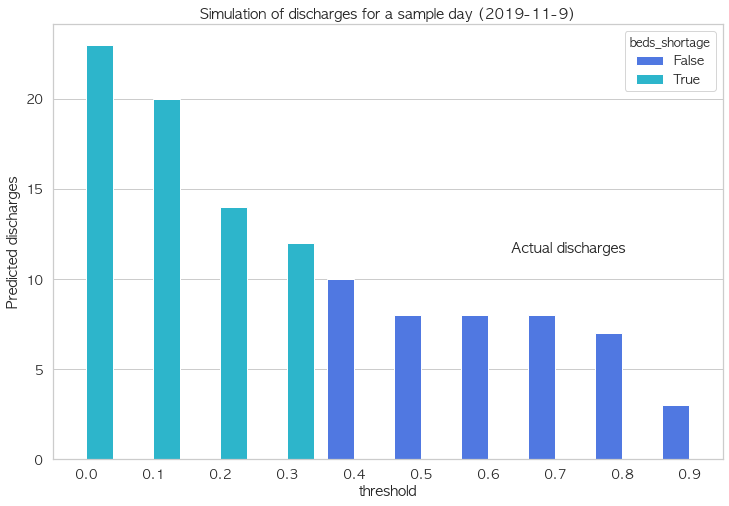

In [15]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="rainbow")
plt.figure(figsize=(12,8))
plt.tight_layout()
ax = sns.barplot(x='threshold',y='predicted_discharges', hue='beds_shortage' ,
             data= sample[sample.threshold *100 % 10 == 0]
            )
ax.set_title('Simulation of discharges for a sample day (2019-11-9)')
ax.set(ylabel='Predicted discharges')
plt.annotate(s='Actual discharges',xy=(0.1,0.5),xytext=(0.7,0.5),xycoords='figure fraction')

plt.show()


plt.figure(figsize=(10,6))
ax = sns.lineplot(x='threshold',y='predicted_discharges', 
             data= prediction_results[(prediction_results['date'] == datetime.date(2019,3,24))],
            )
ax.set_title('')
ax.set(ylabel='')
plt.show()

In [16]:
summary = prediction_results.groupby('threshold')['predicted_discharges_happened'].mean().reset_index()

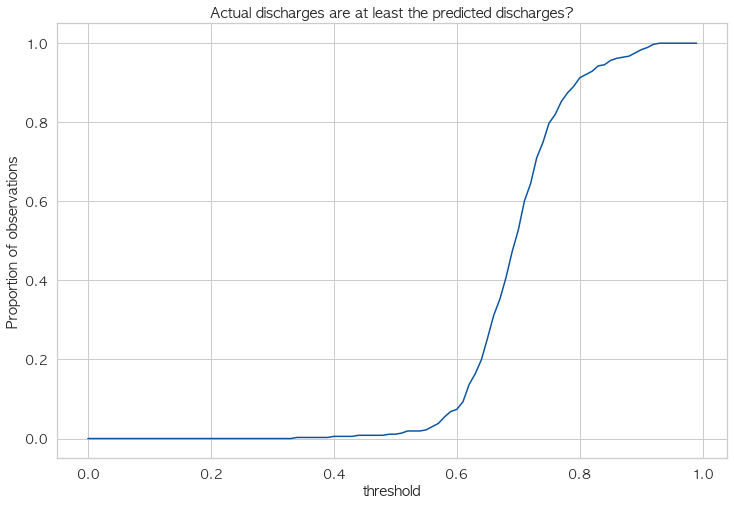

In [17]:
sns.set(style="whitegrid",font_scale=1.2,font='AppleGothic', palette="Blues_r")
plt.figure(figsize=(12,8))
ax = sns.lineplot(x=summary['threshold'],y=summary['predicted_discharges_happened']
            )
ax.set_title('Actual discharges are at least the predicted discharges?')
ax.set(ylabel='Proportion of observations')
plt.show()

In [18]:
pd.set_option('display.max_rows', None)

In [19]:
summary['confidence'] = summary['predicted_discharges_happened']

In [20]:
confidence_dict = {'95': summary[summary['confidence']> 0.95]['threshold'].min(),
                  '90': summary[summary['confidence']> 0.90]['threshold'].min(),
                  '80': summary[summary['confidence']> 0.80]['threshold'].min(),
                  '70': summary[summary['confidence']> 0.70]['threshold'].min()}

In [47]:
import json

In [49]:
with open('confidence_dict.json', 'w') as json_file:
    json.dump(confidence_dict, json_file)

In [50]:
with open('confidence_dict.json', 'r') as json_file:
    confidence_dict = json.load(json_file)

In [51]:
confidence_dict

{'95': 0.85, '90': 0.8, '80': 0.76, '70': 0.73}

In [45]:
def forecast_discharges(date, confidence_thresholds=confidence_dict):
    
    data = Data().load('data/hospital_dataset')
    date_data = data.test.X[data.test.X['date']== date ]
    
    output = {'confidence %': [],
             'lower bound forecast': []}  
    
    with open(r"experiments/optimized_gdbt_model.pkl", "rb") as input_file:
        lgbm_model = pkl.load(input_file)
        
    transformed_data = lgbm_model.pipeline.transform(date_data)
    predictions = lgbm_model.predict(transformed_data)
    
    
    for confidence_level in confidence_thresholds:
        threshold = confidence_thresholds[confidence_level]
        forecast = sum([1 for prob in predictions if prob > threshold])
        
        print(('With {p} % of confidence, number of discharges will be at least {N}'
                .format(p=confidence_level,N=forecast)))
        
        output['confidence %'].append(confidence_level)
        output['lower bound forecast'].append(forecast)
    
    
    return pd.DataFrame(output) 

In [22]:
date_df = data.test.X[data.test.X['date']== unique_dates[20]]

In [23]:
unique_dates[20]

datetime.date(2019, 10, 22)

In [28]:
import warnings
warnings.filterwarnings('ignore')

In [46]:
date = datetime.date(2019,10,22)
forecast_discharges(date)

Loading dataset:  hospital_train_data.parquet
Loading dataset:  hospital_val_data.parquet
Loading dataset:  hospital_test_data.parquet
With 95 % of confidence, number of discharges will be at least 6
With 90 % of confidence, number of discharges will be at least 8
With 80 % of confidence, number of discharges will be at least 9
With 70 % of confidence, number of discharges will be at least 10


,confidence %,lower bound forecast
0,95,6
1,90,8
2,80,9
3,70,10
